##### Creation Date:
##### February 19 2022
##### Created By Alperen KOLAMUC

In [1]:
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn import metrics

In [2]:
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [3]:
import pandas as pd
import numpy as np
import math

##### Prepare


In [4]:
df = pd.read_feather("tmp/bulldozers_1")

In [5]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes + 1 # ortak ağız için

In [6]:
def fix_missing(df, col, name, nan_dict, is_train):
    if is_train:
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+"_NA"] = pd.isnull(col)
                nan_dict[name] = col.median()
                df[name] = col.fillna(nan_dict[name])

    else:
        if is_numeric_dtype(col):
            if name in nan_dict:
                df[name+"_NA"] = pd.isnull(col)
                df[name] = col.fillna(nan_dict[name])
            
            else:
                df[name] = col.fillna(df[name].median())

In [7]:
def proc_df(df, y_fld, nan_dict=None, is_train=True):
    df = df.copy()
    y = df[y_fld].values

    df.drop([y_fld], axis=1, inplace=True)

    if nan_dict is None:
        nan_dict = {}
    
    for n, c in df.items():
        fix_missing(df, c, n, nan_dict, is_train)
        numericalize(df, c, n)

    if is_train:
        return df, y, nan_dict
    
    return df, y

In [8]:
def split_train_val(df, n):
    return(df[:n].copy(), df[n:].copy())

In [9]:
n_valid = 12000
n_train = len(df)-n_valid
raw_train, raw_valid = split_train_val(df, n_train)

In [10]:
x_train, y_train, nas = proc_df(raw_train, 'SalePrice')

In [11]:
x_valid, y_valid = proc_df(raw_valid, 'SalePrice', nan_dict=nas, is_train=False)

#### First Model
* Default Olarak Score'u R^2 alır

In [12]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(x_train, y_train)
m.score(x_train, y_train)

1.0

* Score %100 Doğruluk üretti. Değer 1'e ne kadar yakınsa o kadar doğrudur.
* Ama o kadar çabuk sevinmemek lazım. Bu sadece Train setinde olan

In [13]:
def rmse(y_actual, y_predict):
    return math.sqrt(((y_actual-y_predict)**2).mean())

In [14]:
def print_score(m):

    print(f"RMSLE of train set {rmse(m.predict(x_train), y_train)}")
    print(f"RMSLE of validation set {rmse(m.predict(x_valid), y_valid)}")
    print(f"R^2 of train set {m.score(x_train, y_train)}")
    print(f"R^2 of validation set {m.score(x_valid, y_valid)}")


#### Validation Score'una Bakmak

In [15]:
print_score(m)

RMSLE of train set 9.744327389551985e-17
RMSLE of validation set 0.3419616403057143
R^2 of train set 1.0
R^2 of validation set 0.7649445396465925


> * **Train**: Modelin eğitildiği yer
> * **Validation**: Model seçimi yapılan yer(iterasyon yapılıyor)
> * **Test**: Seçilen model gerçek hayatta ne kadar iyi yapacak testi

# Plot Prediction

In [16]:
import matplotlib.pyplot as plt

In [17]:
def get_sample(df, n):
    idxs = np.random.permutation(len(df))[:n]
    return idxs, df.iloc[idxs].copy()

In [18]:
idxs, x_train = get_sample(x_train, 3000)
y_train = y_train[idxs]

#### Plot

In [19]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: total: 578 ms
Wall time: 80.9 ms
RMSLE of train set 0.1410574810274869
RMSLE of validation set 0.3572096319265884
R^2 of train set 0.9580558324075517
R^2 of validation set 0.7435150523160486


In [20]:
preds = np.array([t.predict(x_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

c:\Users\pc4\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\pc4\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\pc4\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\pc4\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\pc4\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warni

(array([10.55841352, 11.19821472,  9.680344  , 11.53272809, 11.51292546,
        11.51292546, 10.34174248, 10.59663473, 11.39639165, 11.11988288]),
 10.945020300597344,
 11.719939634354555)

In [21]:
preds.shape

(10, 12000)

In [22]:
preds[:,0]

array([10.55841352, 11.19821472,  9.680344  , 11.53272809, 11.51292546,
       11.51292546, 10.34174248, 10.59663473, 11.39639165, 11.11988288])

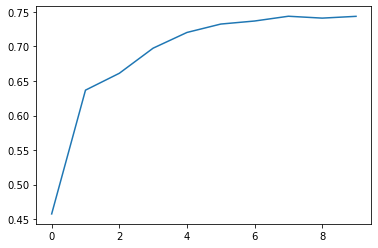

In [23]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In [24]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

RMSLE of train set 0.12419339334422257
RMSLE of validation set 0.3410682371790845
R^2 of train set 0.9674855569762023
R^2 of validation set 0.7661711389970793


In [25]:
m = RandomForestRegressor(n_estimators=60, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

RMSLE of train set 0.11797716303209556
RMSLE of validation set 0.3378641583896938
R^2 of train set 0.970658978537773
R^2 of validation set 0.7705437946687159


In [26]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

RMSLE of train set 0.11593619441903018
RMSLE of validation set 0.3305617502186051
R^2 of train set 0.971665378659119
R^2 of validation set 0.7803552841034609
